In [ ]:
%%capture
!pip install tensorboard==2.9.1
!pip install -q transformers pytorch_lightning emoji soynlp

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
import torchmetrics

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

#TPU 설정
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 전처리 수정

In [ ]:
data_path = '/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_train.csv'
df = pd.read_csv(data_path)
df

,content,label
0,친구 남편이 암으로 세상을 떠났어. 보면서 우리 부부가 둘 다 건강하게 살아있는 게...,0
1,남자친구가 기념일을 까먹었어. 기분이 너무 안좋아.,1
2,숨소리마저 희미해진 할머니가 내게 미안하다고 하시고는 숨을 거두셨어.,3
3,이번에 정말 수고햇어욤 ㅎㅎ,0
4,퇴직을 한지 오래 되다 보니 사람들과 교류가 적어서 왠지 불안해.,1
...,...,...
66139,동기들이 다 퇴사하고 회사에 나만 남게 되었어. 동기들이 보고 싶고 회사에 가는 게...,3
66140,이번에 결혼을 약속했던 여자친구와 헤어지게 되었어.,3
66141,요즘 박보검이 대세더만...,5
66142,친구가 돈을 천만원 빌려달라는데 어떻게 해야 할지 모르겠어.,1


In [ ]:
tokenizer = BertTokenizer.from_pretrained(
            'beomi/kcbert-large'
            )

In [ ]:
def clean(x):
  pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣]+')
  url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
  x = pattern.sub(' ', x)
  x = url_pattern.sub('', x)
  x = x.strip()
  x = repeat_normalize(x, num_repeats=2) # ㅋㅋㅋㅋㅋㅋ .. -> ㅋㅋ 같이 반복되는 문자에 대해 변환 
  return x
sentence = []
for i in df.content:
  sentence.append(clean(str(i)))

In [ ]:
for i,j in enumerate(sentence):
  if len(j) > 150:
    print(i,len(j),j)

6030 164 아니 원래 사드는 비밀리에 배치하고 배치한후에 발표하면 됐을것을 좌파들이 사드배치가 의심된다며 몇년전부터 개난리를 쳐왔고 그러니 비밀리에 못하고 공식적으로 배치결정을 할수밖에 없었고 중국은 당연히 반대하는거고 한국의 정치권이 잘못해놓고 왜 중국을 탓하냐 한국이 중국을 원망할 자격이 있냐 이거야
18588 155 아 결국 친구한테 빌려준 돈을 떼이게 생겼어. 급전이 필요하다고 부탁해서 여러차례 빌려준게 벌써 천 만원이 넘는데 십 년이 지나도 갚을 생각을 안하는것 같아 연락을 했더니 전화번호도 바꾸고 잠적해버렸네. 나뿐만 아니고 이 친구한테 당한 사람이 한둘이 아냐. 아주 상습범이더구만.
19006 299 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기
20022 295 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 사기꾼 바끄네 니가인간이냐?
33626 261 네이버 위키백과 황교안: 군대 면제 의혹, 여성비하 논란, 4

In [ ]:
#soynlp normalize lib ---> ㅋㅋㅋㅋㅋㅋㅋㅋ => ㅋㅋ 토큰내에서 반복되는 문자에 대해서는 줄여줌 but 토큰이 반복되는 형태
repeat_normalize(sentence[19006],num_repeats=2)

'쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기'

In [ ]:
a = re.compile('(.+?\s)+(\\1)')
a.sub('\\1','쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기 쓰레기')

'쓰레기 쓰레기'

In [ ]:
def preprocess_dataframe(df,tokenizer):
    # emojis = ''.join(emoji.UNICODE_EMOJI.keys())
    pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣]+')
    url_pattern = re.compile(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

    def clean(x):
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2) # ㅋㅋㅋㅋㅋㅋ .. -> ㅋㅋ 같이 반복되는 문자에 대해 변환 
        return x

    df['content'] = df['content'].map(lambda x: tokenizer.encode(
        clean(str(x)),
        padding='max_length',
        max_length=150,
        truncation=True,
    ))
    return df

In [ ]:
# for i in df.content:
pro_df = preprocess_dataframe(df,tokenizer)
len(pro_df.content)

66144

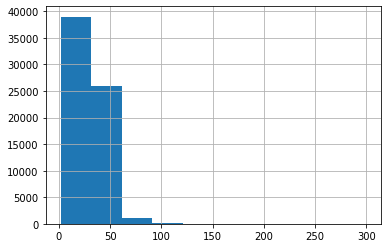

In [ ]:
df['content'].str.len().hist()

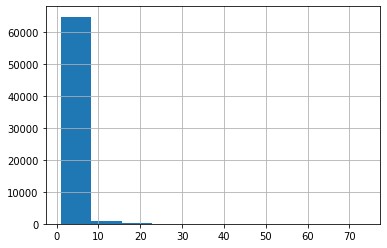

In [ ]:
import numpy as np
df['content'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()


### Data EDA

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/Training/한국어_단발성_대화_데이터셋.xlsx')
data = data.iloc[:,:2]

In [ ]:
data.loc[(data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
data.loc[(data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
data.loc[(data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
data.loc[(data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
data.loc[(data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
data.loc[(data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
data.loc[(data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

In [ ]:
data.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0


In [ ]:
# data.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_data.csv')

In [ ]:
data.Emotion.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=object)

In [ ]:
len_list = []
sen_list = []
for i,j in enumerate(data.Sentence):
    len_list.append(len(j))
    sen_list.append((i,j))


In [ ]:
sen_list.sort()
len_list.sort()
# sorted(len_list,key=len_list[1])
sen_list[-4][0]


38590

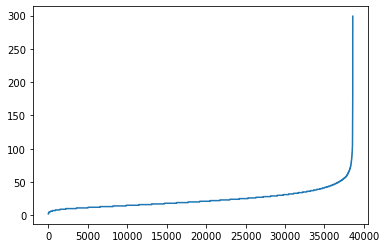

In [ ]:
import seaborn as sns
sns.lineplot(data=len_list)

In [ ]:
for i in sen_list:
    if len(i[1]) == 51:
        print(i[0],i[1])

244 0.056은 약한거 아니냐 지금 이용찬 정찬헌 정성훈 손영민 걸린거보면 싸그리다 취소수준인데
1374 딴데 보는척하면서 저 보는 것 같고,그때 저도 큰눈뜨면서 당황해서 한발 늦게 눈을 돌려요..
1496 빨갱이 기레기새끼 구조작업으로 사람 구하는게 아니라 북한군 죽이는데 쓰는 전쟁무기로 써야지.
1681 물론 저야 첫 달이기에 월급에 대해서는 회사에서도 아직 아무런 말이 없지만솔직히 불안합니다.
1953 나 매일 만원버스 타고 출퇴근하는데 설마 출퇴근시간은 버스 안줄일 거지?? 설마..아닐거야!
2485 저소득층 무너지면 중산층이 저소득층이 되는 상황이 오는건 잘 알것이다 이제 대한민국은 망한다
2689 학점은 좋은편인데아니면 그냥 방통대 유교과나와서 유치원다녀서 임용고시 준비하는게 나을까요..
2780 운동 블로그랑 동영상은 열심히 보고 있는데 혹시 이러다 괜히 자세 잘못잡히지 않을까 싶어서요
2835 혹시 다른 애니중에책걸상이 밀리는 그런 장면있는 애니아시는 분 있나요?ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ
2858 그런데어제 즉 6월 3일에 팬티에 갈색피가 비쳐서생리대를 했는데 색깔이 계속 갈색이에요...
3680 미안하다는 말을 너무 많이 해서 미안하다고 이제 말도 못하겟고어떻게 하면 풀수 잇을까요??ㅜ
4572  그때쯤 부터일주일에 두세번정도 화장실 가서 볼일[소변] 보고화장지에 묻은거 확인 해보면..
4889 AI와 로봇으로 양극화는 더 심해질 것이므로 당장 대책을 마련해야 하는데 정부의 상태가?..
6027 3살만 더 붙이면 20살이네 국제 결혼도 아니고 국내 커플 20살 차이는 세계 십안에 들것네
6452 술먹고 운전하겠다는거 아니라 전날 먹은 술 혹시나 불면 나올까 걱정될때 쓰라고 달아논거 ㅡㅡ
6476 호수같은거 대학생들이 술마시고 빠지는 경우는 있는데... 폰이 다른곳에 가있었다는건 뭐지??
6761 어제부터 1998 작품 kbs 야망의 전설 보는중인데 90년대 히트작은 거의 최수종이더만..
7274 남자들 버스에서 매일 만나는 호감가는 여자가있으면

In [ ]:
len('하여간 얼굴색 하나 안 변하고 뻔뻔하게 거짓말 잘하는 여자라는건 대한민국에서 알아줘야 한다.')

51

In [ ]:
data.Emotion.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=object)

In [ ]:
# x_train,x_val = train_test_split(data,test_size=0.2,random_state=42)
# x_train.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_train.csv')
# x_val.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_val.csv')

In [ ]:
li = [x for x in range(5)]

### data_load

In [ ]:
data_pro = pd.read_excel('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/data_processing_re(82681).xlsx')
data_pro

,content,emotion,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,기쁨,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,긴장,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,긴장,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,기쁨,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,평화,2
...,...,...,...
82676,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,분노,4
82677,재미가 없으니 망하지,분노,4
82678,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,분노,4
82679,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,분노,4


In [ ]:
data_pro = data_pro.drop(['emotion'],axis=1)
data_pro

,content,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,2
...,...,...
82676,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,4
82677,재미가 없으니 망하지,4
82678,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,4
82679,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,4


In [ ]:
x_tr,x_val = train_test_split(data_pro,stratify=data_pro['label'],test_size=0.2,random_state=42)

In [ ]:
x_tr.shape,x_val.shape

((66144, 2), (16537, 2))

In [ ]:
x_tr.label.value_counts(),x_val.label.value_counts()

(3    19065
 4    16433
 1    16178
 0     8869
 5     3861
 2     1738
 Name: label, dtype: int64, 3    4766
 4    4108
 1    4045
 0    2218
 5     966
 2     434
 Name: label, dtype: int64)

In [ ]:
x_tr.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_train.csv',index=False)
x_val.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_val.csv',index=False)

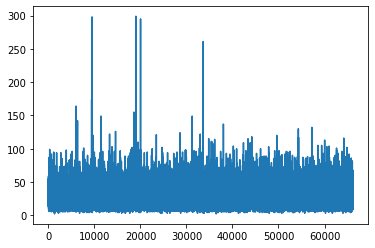

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
tr = pd.read_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_train.csv')
leng = []
for i in tr.content:
    leng.append(len(i))
sns.lineplot(data=leng)

### model setting

In [ ]:
class Arg:
    random_seed: int = 42 # Random Seed
    pretrained_model: str = 'beomi/kcbert-large'  # Transformers PLM name
    pretrained_tokenizer: str = ''  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    auto_batch_size: str = 'power'  # Let PyTorch Lightening find the best batch size 
    batch_size: int = 0  # Optional, Train/Eval Batch Size. Overrides `auto_batch_size` 
    lr: float = 5e-6  # Starting Learning Rate
    epochs: int = 5  # Max Epochs
    max_length: int = 150  # Max Length input size
    report_cycle: int = 1000  # Report (Train Metrics) Cycle
    train_data_path: str = '/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_train.csv'  # Train Dataset file 
    val_data_path: str = '/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_val.csv'  # Validation Dataset file 
    cpu_workers: int = os.cpu_count()  # Multi cpu workers
    test_mode: bool = False  # Test Mode enables `fast_dev_run`
    optimizer: str = 'AdamW'  # AdamW vs AdamP
    lr_scheduler: str = 'exp'  # ExponentialLR vs CosineAnnealingWarmRestarts
    fp16: bool = False  # Enable train on FP16
    tpu_cores: int = 0  # Enable TPU with 1 core or 8 cores
    checkpoint: str = '/content/drive/MyDrive/Aiffel/AIFFELTON/model/checkpoint/KcBert-epoch=01-val_loss=0.75-v1.ckpt'

args = Arg()

In [ ]:
# args.tpu_cores = 8  # Enables TPU
args.fp16 = True  # Enables GPU FP16
args.batch_size = 16  # Force setup batch_size
tr_met_list,val_met_list = [],[]
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = '/content/drive/MyDrive/Aiffel/AIFFELTON/model/checkpoint/',
    filename = 'KcBert-{epoch:02d}-{val_loss:.2f}'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    verbose=True,
    mode='min')

In [ ]:
class Model(LightningModule):
    def __init__(self, options):
        super().__init__()
        self.args = options
        self.bert = BertForSequenceClassification.from_pretrained(self.args.pretrained_model,num_labels=6) #num_labels == 태그 개수
        self.tokenizer = BertTokenizer.from_pretrained(
            self.args.pretrained_tokenizer
            if self.args.pretrained_tokenizer
            else self.args.pretrained_model
        )
        # #metrics
        # self.train_acc = torchmetrics.Accuracy()
        # self.train_recall = torchmetrics.Recall(num_classes=6,average="")
        # self.train_f1 = torchmetrics.F1(number_classes=6,
        # average="weighted")
        
        # self.val_acc = torchmetrics.Accuracy()
        # self.val_f1 = torchmetrics.F1(number_classes=6,
        # average="weighted")


    def forward(self, **kwargs):
        return self.bert(**kwargs)

    def training_step(self, batch, batch_idx):
        data_, labels = batch
        output = self(input_ids=data_, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits
        
        preds = logits.argmax(dim=-1)

        y_true = labels.cpu().numpy()
        y_pred = preds.cpu().numpy()

        # Acc, Precision, Recall, F1
        metrics = [
            metric
            for metric in
            (accuracy_score(y_true=y_true, y_pred=y_pred),
             precision_score(y_true=y_true, y_pred=y_pred,average='weighted'),
             recall_score(y_true=y_true, y_pred=y_pred,average='weighted'),
             f1_score(y_true=y_true, y_pred=y_pred,average='weighted'))
        ]
        # metrics = [
        #     metric(y_true=y_true, y_pred=y_pred,average='weighted')
        #     for metric in
        #     (precision_score, recall_score, f1_score)
        # ]

        tensorboard_logs = {
            'train_loss': loss.cpu().detach().numpy().tolist(),
            'train_acc': metrics[0],
            'train_precision': metrics[1],
            'train_recall': metrics[2],
            'train_f1': metrics[3],
        }
        tr_met_list.append(tensorboard_logs)
        if (batch_idx % self.args.report_cycle) == 0:
            print()
          
            pprint(tensorboard_logs)
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        data_, labels = batch
        output = self(input_ids=data_, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred,
        }

    def validation_epoch_end(self, outputs):
        loss = torch.tensor(0, dtype=torch.float)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        _loss = loss / len(outputs)

        loss = float(_loss)
        y_true = []
        y_pred = []

        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']

        # Acc, Precision, Recall, F1
        metrics = [
            metric
            for metric in
            (accuracy_score(y_true=y_true, y_pred=y_pred),
             precision_score(y_true=y_true, y_pred=y_pred,average='weighted'),
             recall_score(y_true=y_true, y_pred=y_pred,average='weighted'),
             f1_score(y_true=y_true, y_pred=y_pred,average='weighted'))
        ]
        # metrics = [
        #     metric(y_true=y_true, y_pred=y_pred,average='weighted')
        #     for metric in
        #     (precision_score, recall_score, f1_score)
        # ]
        self.log('val_loss',loss)
        tensorboard_logs = {
            'val_loss': loss,
            'val_acc': metrics[0],
            'val_precision': metrics[1],
            'val_recall': metrics[2],
            'val_f1': metrics[3],
        }
        val_met_list.append(tensorboard_logs)
        print()
        pprint(tensorboard_logs)
        return {'loss': _loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        if self.args.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.args.lr)
        elif self.args.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.args.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.args.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.args.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }

    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')

    def preprocess_dataframe(self, df):
        # emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

        def clean(x):
            x = pattern.sub(' ', x)
            x = url_pattern.sub('', x)
            x = x.strip()
            x = repeat_normalize(x, num_repeats=2) # ㅋㅋㅋㅋㅋㅋ .. -> ㅋㅋ 같이 반복되는 문자에 대해 변환 
            return x

        df['content'] = df['content'].map(lambda x: self.tokenizer.encode(
            clean(str(x)),
            padding='max_length',
            max_length=self.args.max_length,
            truncation=True,
        ))
        return df

    def train_dataloader(self):
        df = self.read_data(self.args.train_data_path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['content'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.args.batch_size or self.batch_size,
            shuffle=True,
            num_workers=self.args.cpu_workers,
        )

    def val_dataloader(self):
        df = self.read_data(self.args.val_data_path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['content'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.args.batch_size or self.batch_size,
            shuffle=False,
            num_workers=self.args.cpu_workers,
        )


In [ ]:
def main():
    print("Using PyTorch Ver", torch.__version__)
    print("Fix Seed:", args.random_seed)
    seed_everything(args.random_seed)
    model = Model(args)
    # summary(model)
    print(":: Start Training ::")
    trainer = Trainer(
        resume_from_checkpoint=args.checkpoint,
        callbacks = [checkpoint_callback,early_stopping],
        max_epochs=args.epochs,
        fast_dev_run=args.test_mode,
        num_sanity_val_steps=None if args.test_mode else 0,
        auto_scale_batch_size=args.auto_batch_size if args.auto_batch_size and not args.batch_size else False,
        # For GPU Setup
        deterministic=torch.cuda.is_available(),
        gpus=-1 if torch.cuda.is_available() else None,
        precision=16 if args.fp16 else 32,
        # For TPU Setup
        # tpu_cores=args.tpu_cores if args.tpu_cores else None,
    )
    trainer.fit(model)

In [ ]:
# from torchsummary import summary
# summary(model)


In [ ]:
import warnings
warnings.filterwarnings('ignore') 
main()

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Using PyTorch Ver 1.12.1+cu113
Fix Seed: 42


Some weights of the model checkpoint at beomi/kcbert-large were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initial

:: Start Training ::


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Aiffel/AIFFELTON/model/checkpoint/KcBert-epoch=01-val_loss=0.75-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 334 M 
-------------------------------------------------------
334 M     Trainable params
0         Non-trainable param

Training: 4134it [00:00, ?it/s]


{'train_acc': 0.9375,
 'train_f1': 0.9398809523809524,
 'train_loss': 0.49385738372802734,
 'train_precision': 0.953125,
 'train_recall': 0.9375}

{'train_acc': 0.75,
 'train_f1': 0.7708333333333333,
 'train_loss': 0.8125190734863281,
 'train_precision': 0.8385416666666666,
 'train_recall': 0.75}

{'train_acc': 0.9375,
 'train_f1': 0.9365079365079365,
 'train_loss': 0.381955623626709,
 'train_precision': 0.95,
 'train_recall': 0.9375}


In [ ]:
loss,acc,precision,recall,f1 = [],[],[],[],[]
for i in range(len(tr_met_list)):
    loss.append(tr_met_list[i]['train_loss'])
    acc.append(tr_met_list[i]['train_acc'])
    precision.append(tr_met_list[i]['train_precision'])
    recall.append(tr_met_list[i]['train_recall'])
    f1.append(tr_met_list[i]['train_f1'])

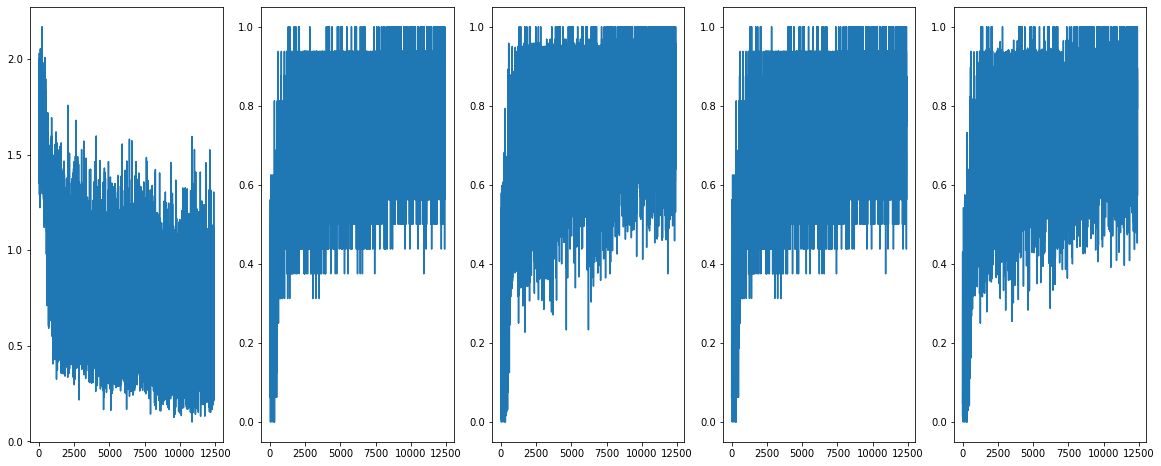

<Figure size 1440x576 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, 5,figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=loss,ax=axes[0])
sns.lineplot(data=acc,ax=axes[1])
sns.lineplot(data=precision,ax=axes[2])
sns.lineplot(data=recall,ax=axes[3])
sns.lineplot(data=f1,ax=axes[4])

In [ ]:
loss,acc,precision,recall,f1 = [],[],[],[],[]
for i in range(len(val_met_list)):
    loss.append(val_met_list[i]['val_loss'])
    acc.append(val_met_list[i]['val_acc'])
    precision.append(val_met_list[i]['val_precision'])
    recall.append(val_met_list[i]['val_recall'])
    f1.append(val_met_list[i]['val_f1'])

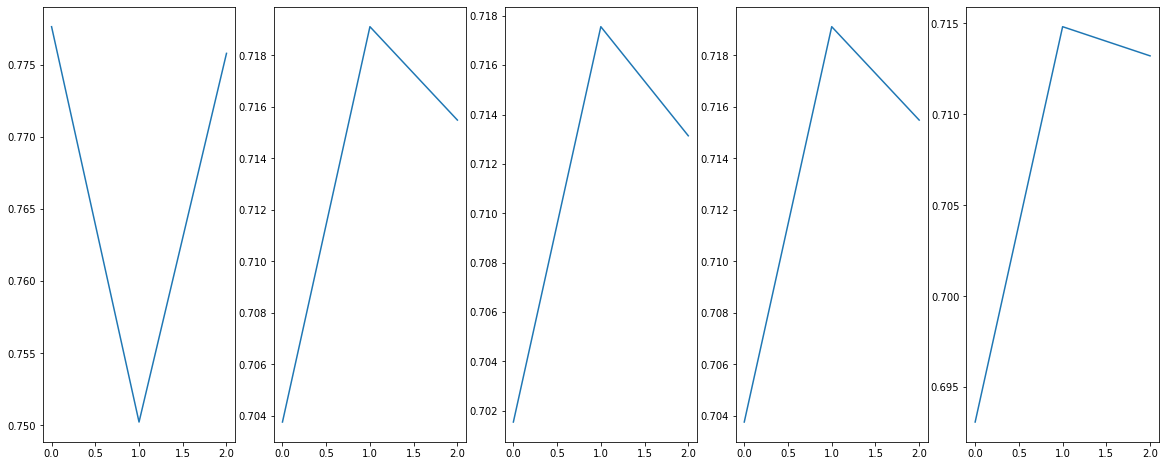

<Figure size 1440x576 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, 5,figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=loss,ax=axes[0])
sns.lineplot(data=acc,ax=axes[1])
sns.lineplot(data=precision,ax=axes[2])
sns.lineplot(data=recall,ax=axes[3])
sns.lineplot(data=f1,ax=axes[4])

In [ ]:
# model = my_model(layers=3, drop_rate=0)
# trainer = pl.Trainer()
# chk_path = "/path_to_checkpoint/my_checkpoint_file.ckpt"
# model2 = my_model.load_from_checkpoint(chk_path, layers=3, drop_rate=0)
# results = trainer.test(model=model2, datamodule=my_datamodule, verbose=True)
class MyLightningModule(LightningModule):
    def __init__(self, learning_rate, another_parameter, *args, **kwargs):
        super().__init__()
        self.save_hyperparameters()


chk_path = '/content/drive/MyDrive/Aiffel/AIFFELTON/model/checkpoint/KcBert-epoch=01-val_loss=0.75-v1.ckpt'
model2 = MyLightningModule.load_from_checkpoint(chk_path)
results = trainer.test(model=model2, verbose=True)


TypeError: ignored